Make a butler, but we don't point it at the usual repo root, we point it at the location of best reduction of the data to date.  
For the current version of this, see `setup_script.md`

In [1]:
repoDir = '/project/shared/auxTel/rerun/mfl/slurmRun/'

import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(repoDir)

<ipython-input-1-510b973f7d5d>:4: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(repoDir)
<ipython-input-1-510b973f7d5d>:4: FutureWarning: Gen2 Butler has been deprecated (LatissMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(repoDir)


Next, we make a NightReporter object. This is just a useful little toy project (read: not well supported, but might be helpful) to will help understand (and visualise) the night's observations. Try poking it to see what it does, some it it, _e.g._ reporter.printObsTable() is quite useful for getting a quick overview of the observations of the night.

In [2]:
from lsst.rapid.analysis.nightReport import NightReporter
reporter = NightReporter(repoDir, "2020-03-12")

Loaded data for seqNums 1 to 378


In [3]:
dayObs = '2020-03-12'

In [4]:
%matplotlib inline

See what objects we looked at over the course of the selected dayObs, so that we can pick one that sampled a nice range of airmasses to examine further.

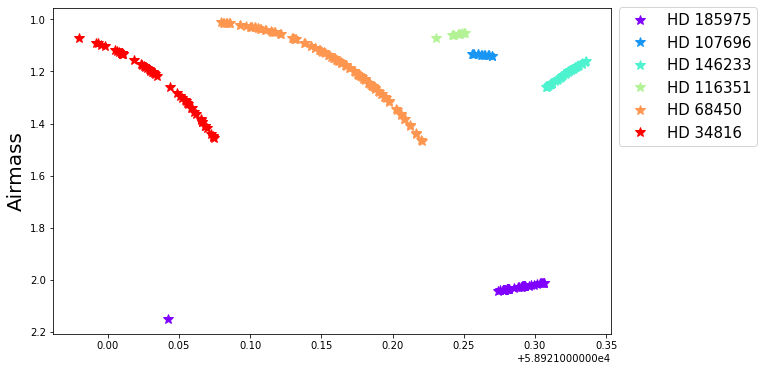

In [5]:
reporter.plotPerObjectAirMass()

In [6]:
objName = 'HD 34816'

Here we find out from the butler which sequence numbers are observations of that star. Note that a) some will be dispersed, but some will likely be direct images or donuts, etc, and that b) of the dispersed images, some might not have run all the way through the pipeline without failure, so we're going to need to test for that.

In [7]:
seqNums = butler.queryMetadata('raw', 'seqNum', dayObs=dayObs, object=objName)

Here, for the seqNums, we ask the butler to check if the output of Spectractor actually exists, such that it can be retrieved.

In [8]:
extracted = []
for seqNum in seqNums:
    if butler.datasetExists('spectraction', dayObs=dayObs, seqNum=seqNum):
        extracted.append(seqNum)

Grab a random single result just so we've got an object to poke at, such that we can use it to help us write the code that follows.

In [9]:
result = butler.get('spectraction', dict(dayObs=dayObs, seqNum=extracted[0]))

In [10]:
result.spectrum.header

SIMPLE  =                    T                                                  
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  282                                                  
NAXIS2  =                   98                                                  
EXTEND  =                    T                                                  
TARGET  = 'HD 34816'           / name of the target in the image                
REDSHIFT= '6.7e-05 '           / redshift of the target                         
GRATING = 'ronchi90lpmm'       / name of the disperser                          
ROTANGLE=  -0.6024210681272443 / [deg] angle of the dispersion axis             
D2CCD   =    175.0810652322949 / [mm] distance between disperser and CCD        
LSHIFT  =                  0.0                                                  
PARANGLE=    136.75748374578

Build a dictionary of all the results for our sequence numbers:

In [11]:
results = {}
for seqNum in extracted:
    results[seqNum] = butler.get('spectraction', dayObs=dayObs, seqNum=seqNum)

Pick a random extraction, grab its lines, and see what their names are

In [12]:
for lineNum, line in enumerate(result.spectrum.lines.lines):
    print(lineNum, line.label)

0 $Fe_{I}$
1 $Ca_{II}$
2 $Ca_{II}$
3 $H\epsilon$
4 $H\delta$
5 $Fe_{I}$
6 $H\gamma$
7 $Fe_{I}$
8 $H\beta$
9 $Mg_{I}$
10 $Mg_{I}$
11 $Fe_{I}$
12 $H\alpha$
13 $O_2(B)$
14 
15 $O_2$
16 $O_2(Z)$
17 $O_2(Y)$
18 $H_2 O$


Now that we've poked a line to see how it quacks, lets look over all the extractions, pull the O2 line out, and plot its equivalent width against airmass

In [13]:
airmasses, eqWidths = [], []
for seqNum in results.keys():
    airmass = results[seqNum].spectrum.airmass
    line = [line for line in results[seqNum].spectrum.lines.lines if line.label=='$O_2$']
    eqWidth = line[0].fit_eqwidth_data
    airmasses.append(airmass)
    eqWidths.append(eqWidth)

In [14]:
import matplotlib.pyplot as plt

NB: This is a garbage in, garbage out situation. The current reductions are known-bad in many places, and this is just a toy example showing how one can access data, so don't freak out that it's bad!

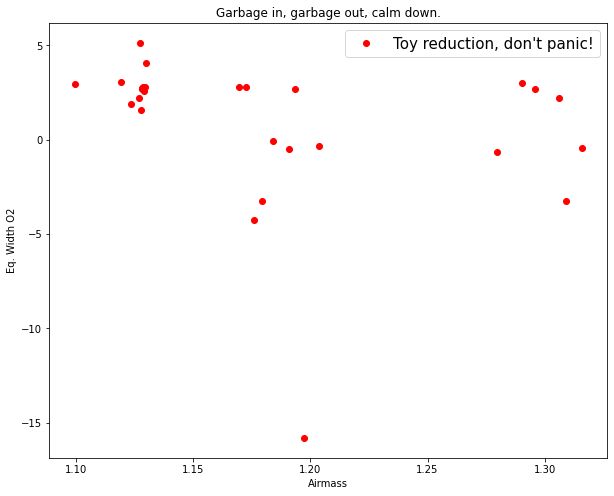

In [15]:
fig = plt.figure(figsize=(10, 8))
_ = plt.plot(airmasses, eqWidths, 'or', label="Toy reduction, don't panic!")
_ = plt.xlabel('Airmass')
_ = plt.ylabel('Eq. Width O2')
_ = plt.legend(fontsize=15)
_ = plt.title('Garbage in, garbage out, calm down.')